<a href="https://colab.research.google.com/github/ItaiPemp/Simple-Transformer/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt

***Structure:***

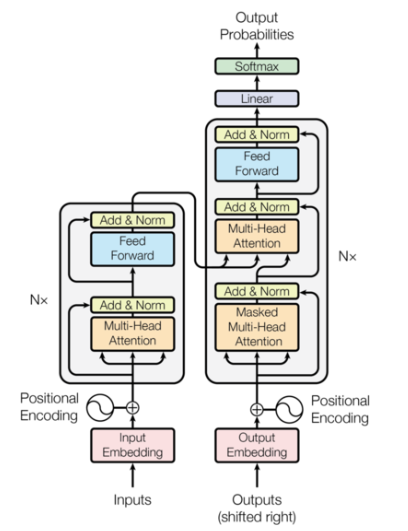

#positional encoding

In [ ]:
class PositionalEncoding(nn.Module):
    """
    compute sinusoid encoding.
    """

    def __init__(self, d_model, max_len):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.embed_dim = d_model


        pe = torch.zeros(max_len,self.embed_dim)
        for pos in range(max_len):
            for i in range(0,self.embed_dim,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """

        # make embeddings relatively larger
       # x = x * math.sqrt(self.embed_dim)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + self.pe[:,:seq_len]
        return x

#Transformer

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(TransformerBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding (d_model)
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads

        """
        self.attention = nn.MultiheadAttention(embed_dim, n_heads,batch_first=True)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.feed_forward = nn.Sequential(
                          nn.Linear(embed_dim, expansion_factor*embed_dim), # d_model -> d_model*4 ->d_model
                          nn.ReLU(),
                          nn.Linear(expansion_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.0)
        self.dropout2 = nn.Dropout(0.0)

    def forward(self,key,query,value,mask = None):

        """
        Args:
           key: kye matrix
           query: query vectory:
           value: value vector
           norm2_out: output of transformer block

        """

        attention_out,_ = self.attention(key,query,value,attn_mask  = mask)  #batch*max_sequence*d_model
        attention_residual_out = attention_out + value  #same dimention. add residual connections
        norm1_out = self.dropout1(self.norm1(attention_residual_out)) #batch*max_sequence*d_model

        feed_fwd_out = self.feed_forward(norm1_out) #batch*max_sequence*d_model -> ##batch*max_sequence*(d_model*4) -> #batch*max_sequence*d_model
        feed_fwd_residual_out = feed_fwd_out + norm1_out #batch*max_sequence*d_model
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out)) #batch*max_sequence*d_model

        return norm2_out

In [ ]:
class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : length of max input sequence
        embed_dim: dimension of embedding
        num_layers: number of encoder layers
        expansion_factor: factor which determines number of linear layers in feed forward layer
        n_heads: number of heads in multihead attention

    Returns:
        out: output of the encoder
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerEncoder, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embed_dim) #need to add device here
        self.positional_encoder = PositionalEncoding(embed_dim, seq_len)#need to add device here

        self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])

    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out,out,out)

        return out  #32x10x512

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads

        """
        self.attention = nn.MultiHeadAttention(embed_dim, n_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.2)
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)


    def forward(self, key, query, x,mask):

        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           mask: mask to be given for multi head attention
        Returns:
           out: output of transformer block

        """

        #we need to pass mask mask only to fst attention
        attention = self.attention(x,x,x,mask=mask) #32x10x512 multi head self masked attention
        value = self.dropout(self.norm(attention + x))

        out = self.transformer_block(key, query, value) #key and value will be taken from encoder


        return out

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerDecoder, self).__init__()
        """
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention

        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = PositionalEncoding(embed_dim, seq_len)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=4, n_heads=8)
                for _ in range(num_layers)
            ]

        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask):

        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """


        x = self.word_embedding(x)  #32x10x512
        x = self.position_embedding(x) #32x10x512
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask)

        out = F.softmax(self.fc_out(x))

        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length,num_layers=2, expansion_factor=4, n_heads=8):
        super(Transformer, self).__init__()

        """
        Args:
           embed_dim:  dimension of embedding
           src_vocab_size: vocabulary size of source
           target_vocab_size: vocabulary size of target
           seq_length : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention

        """

        self.target_vocab_size = target_vocab_size

        self.encoder = TransformerEncoder(seq_length, src_vocab_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        self.decoder = TransformerDecoder(target_vocab_size, embed_dim, seq_length, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)


    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        trg_len = trg.size(dim=1)
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask

    def decode(self,src,trg):
        """
        for inference
        Args:
            src: input to encoder
            trg: input to decoder
        out:
            out_labels : returns final prediction of sequence
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size,seq_len = src.shape[0],src.shape[1]
        #outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size)
        out = trg
        for i in range(seq_len): #10
            out = self.decoder(out,enc_out,trg_mask) #bs x seq_len x vocab_dim
            # taking the last token
            out = out[:,-1,:]

            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out,axis=0)


        return out_labels

    def forward(self, src, trg):
        """
        Args:
            src: input to encoder
            trg: input to decoder
        out:
            out: final vector which returns probabilities of each target word
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)

        outputs = self.decoder(trg, enc_out, trg_mask)
        return outputs

In [ ]:
class TransformerDecoderOnly(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerDecoderOnly, self).__init__()
        """
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention

        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = PositionalEncoding(embed_dim, seq_len)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(embed_dim, expansion_factor=4, n_heads=8)
                for _ in range(num_layers)
            ]

        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.0)



    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        trg_len= trg.size(dim=1)
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len)))
        trg_mask[trg_mask == 0] = float('-inf')


        return trg_mask
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

    def forward(self, x):

        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """

        mask = self.make_trg_mask(x)
        x = self.word_embedding(x)  #32x10x512
        x = self.position_embedding(x) #32x10x512
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, x, x, mask)

        #out = F.softmax(self.fc_out(x)) #can possibly remove this
        out = self.fc_out(x)
        return out

#preparing data

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-11-13 23:59:13--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.19’

input.txt.19        100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-11-13 23:59:13 (23.0 MB/s) - ‘input.txt.19’ saved [1115394/1115394]



In [ ]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [ ]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53




#training




In [ ]:
from torchvision import models
from torchsummary import summary
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
max_iters = 4000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
n_head = 8
n_layer = 8
dropout = 0.0
# ------------

model = TransformerDecoderOnly(target_vocab_size=vocab_size,embed_dim=n_embd,seq_len = block_size,num_layers=n_layer,n_heads=n_head)
model.to(device)

TransformerDecoderOnly(
  (word_embedding): Embedding(65, 128)
  (position_embedding): PositionalEncoding()
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (dropout1): Dropout(p=0.0, inplace=False)
      (dropout2): Dropout(p=0.0, inplace=False)
    )
  )
  (fc_out): Linear(in_features=128, out_features=65, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [ ]:
@torch.no_grad()
def estimate_loss():
    #ce = F.cross_entropy()
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = torch.swapaxes(model(X),1,2)
            loss = F.cross_entropy(logits,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#ce = F.cross_entropy()
for iter in range(max_iters):
    xb, yb = get_batch('train')
    logits = torch.swapaxes(model(xb),1,2)

    loss = F.cross_entropy(logits,yb)
    # every once in a while evaluate the loss on train and val sets
    #if iter % eval_interval == 0 or iter == max_iters - 1:
        #losses = estimate_loss()
       # print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data


    # evaluate the loss
    if(iter%10 == 0):
      print("iter: " + str(iter))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90
iter: 100
iter: 110
iter: 120
iter: 130
iter: 140
iter: 150
iter: 160
iter: 170
iter: 180
iter: 190
iter: 200
iter: 210
iter: 220
iter: 230
iter: 240
iter: 250
iter: 260
iter: 270
iter: 280
iter: 290
iter: 300
iter: 310
iter: 320
iter: 330
iter: 340
iter: 350
iter: 360
iter: 370
iter: 380
iter: 390
iter: 400
iter: 410
iter: 420
iter: 430
iter: 440
iter: 450
iter: 460
iter: 470
iter: 480
iter: 490
iter: 500
iter: 510
iter: 520
iter: 530
iter: 540
iter: 550
iter: 560
iter: 570
iter: 580
iter: 590
iter: 600
iter: 610
iter: 620
iter: 630
iter: 640
iter: 650
iter: 660
iter: 670
iter: 680
iter: 690
iter: 700
iter: 710
iter: 720
iter: 730
iter: 740
iter: 750
iter: 760
iter: 770
iter: 780
iter: 790
iter: 800
iter: 810
iter: 820
iter: 830
iter: 840
iter: 850
iter: 860
iter: 870
iter: 880
iter: 890
iter: 900
iter: 910
iter: 920
iter: 930
iter: 940
iter: 950
iter: 960
iter: 970
iter: 980
iter: 990
iter: 1000


#generation with smaller model

In [ ]:
context = torch.zeros((5, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))



QUEEN.

ETRBBIOKEN OF VI:
I pray, I men, the meetly loss this vicent,
I have done him mirdage be for this could,
Prace ent age fall the teltch times a gaill.
Then Catill was I begoar, your stir thove note with
Hereforg, the deep I be cating'd her on this fals,
I doth the believe draw'd your men: if all.

HENRY BOLINGBROKE:
Why, who's own back, Largt, when I calle, and you should thee,
And threefore pray youths! Lair'd with power.

GLOUCESTER:
Downer there at on cornat:
Ay, i' drank'r, any any lyord of me honour'd to decer'n.

FRIABELIxFFHARS:
O crisil? I can Clarenal that unt want's, whichiref
Site, to thine apdon, but, I tell, not pie.
I watel that nothing this seve
Ay friend devilly generan'd you seclf?
Incan you have impren thine endity the won,
Livarulcte thing lay a me before upone
And, withal, 'canne this no wence imself.

ANVOL:
Tell they rothe? But: if that a delity with out!

MENENIURY:
I spue, hast condue, and like me take of he her,
I be do stelle pay it with prompoy good 

In [ ]:
print(decode(model.generate(context, max_new_tokens=2000)[1].tolist()))


The but saccess of the halte stains to the king cold,
I sto with the heart, sir, sise you power?
ORld, we'll alah right stile I feave seal and knoing,
That har upon of them-in lence prent.

UCIOLANUS:
I say you these mistrictarge? and, this with not in this right
With ext our against;
Like all your abut? and?

ROMEO:
O, stir, I well, my let a more and my lumt,
I knows poue death-the fally our grace:

ISABELLA:
This with, I can Canspeate!

GLOUCESTERer:
If can whate you all'd and it cupfle,
Beward up thy guess and my 
That thus!
God condent.

Nay thy keeps!
That what havice the remited, this friend
Are is to duly like roje am knowled delifer.

CAPULO:
Af you go says friend out dest, with and doth thou encel,
This what as it watch your hear ben a enexest.

First?
I kill you well; pray, for content pass and shaw thy dispares
Were it come roithe the mother this bear;'
How is Eluction as this tare oser'd spran'd aspy'd,
If please, this beaz a won, my let overtt.

PETRPER:
But what patle; t

#generation with larger model

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))


Fir Lest of Trey, King Martagaret, as am I clock'd gows
Your lant about of prayer's other desay;
Remains Rome.

DUKE OF AUMERLEO:
Tell down, marshy, what virtuous limbs of her,
Worp Sicilianus were hath begon here I did
Break me taller slace.

First Senar'd to name, that I was moost this,
Much on Roman, wife to seems with the quake, swears;
And by sings my heavies caps not further parts,
And Deny'd, Say Annnion most in leave you;
For sweet with you forge, that surply may,
Where bettern keepiss the traitor. Hastily none,
Some blood of purper villain?

Clo, you why?

Second Servingman:
Tether lead her chosteful sleptents of you.

Nurse:
'Tis that affect, our chance is'llly remain's con
privents that it leave adven from you bright.

GREEGO:
By are he dequire should have forced by
Some robbbey, our must are anly diremione,
Not your help of the glade winth spring: swear be
Has beggar'd spake a suit upon joyful and withings:
As called now, my lord, of thee
As your power's cross brother, I, 

In [ ]:
context = torch.zeros((3, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[2].tolist()))


BANN's EDirling, George:
And youoh thought you come: yet had some for lame.

VARGAN:
Ye are lady, is your gracious way; why be for
yieldied
Where you are from much shows say you not to be!
The dray, in her is Janng Sakes, gont abodurs!

Girl:
Even better worthy I pilot must my send.

LEONTES:
Sir, you rubze the sink
Nourfilling, you see that is all blows along.

Second Advicer:
No trybuness, what is, what not such deterble stail.

Now Romano, queen him all thee encounter
Is repenit enemiage do, as I
I fend these with a preceminess's sonamer!
O, Rome, shall be alive, bear'd your transpisity,
The dearencing and she madminable and fellows;
And spread fapely than I can, for yours
Provost, Bohemia:' willl lie wife
Can time with bread too day the merrily were
That ever out will not do are as and cure most, let,
Puse, from all
Hastisful sated, all prendone dead,
But be all fear. What mounation, will thou speak?
Thy thanks desperated; I will night enterie;
Will show myself say I home father.
